In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from math import sqrt
from tensorflow.keras.optimizers import Adam as Adam
from tensorflow.keras.regularizers import l2

In [83]:
# Load data
df = pd.read_csv('drive/MyDrive/Dataset/AXISBANK.csv')  # Using dataset here

df = df[['Close']].values

In [84]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

In [85]:
train_size = int(len(df) * 0.6)
train, test = df[0:train_size], df[train_size:]

In [86]:
def create_dataset(data, lookback=4):
    X, Y = [], []
    for i in range(len(data) - lookback - 1):
        X.append(data[i:(i + lookback), 0])   # Features (time steps)
        Y.append(data[i + lookback, 0])        # Target (next step)
    return np.array(X), np.array(Y)

In [87]:
lookback = 30
X_train, y_train = create_dataset(train, lookback)
X_test, y_test = create_dataset(test, lookback)

In [88]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [89]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(lookback, 1)))
model.add(Dropout(0.1))  # Helps prevent overfitting
model.add(BatchNormalization())  # Normalizes activations

model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(32))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [90]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7)
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.1633 - mae: 0.0823 - mse: 0.0163 - val_loss: 0.1841 - val_mae: 0.3179 - val_mse: 0.1038
Epoch 2/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0694 - mae: 0.0386 - mse: 0.0027 - val_loss: 0.1172 - val_mae: 0.2786 - val_mse: 0.0798
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0341 - mae: 0.0324 - mse: 0.0020 - val_loss: 0.0707 - val_mae: 0.2208 - val_mse: 0.0502
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0195 - mae: 0.0265 - mse: 0.0013 - val_loss: 0.0194 - val_mae: 0.0742 - val_mse: 0.0066
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0127 - mae: 0.0247 - mse: 0.0011 - val_loss: 0.0105 - val_mae: 0.0345 - val_mse: 0.0018
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0092 - mae: 0.0251 - mse: 0.0012 - val_loss: 0.0093 - val_mae: 0.0477 - val_mse: 0.0030
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0071 - mae: 0.0252 - mse

In [91]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train]).T
y_test = scaler.inverse_transform([y_test]).T

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [92]:
print("Train RMSE:", sqrt(mean_squared_error(y_train, train_predict)))
print("Test RMSE:", sqrt(mean_squared_error(y_test, test_predict)))
print("Test MAE:", mean_absolute_error(y_test, test_predict))
print("Test R2 Score:", r2_score(y_test, test_predict))

Train RMSE: 26.647111565590787
Test RMSE: 66.54825685580691
Test MAE: 31.061938193560106
Test R2 Score: 0.9648185345568053


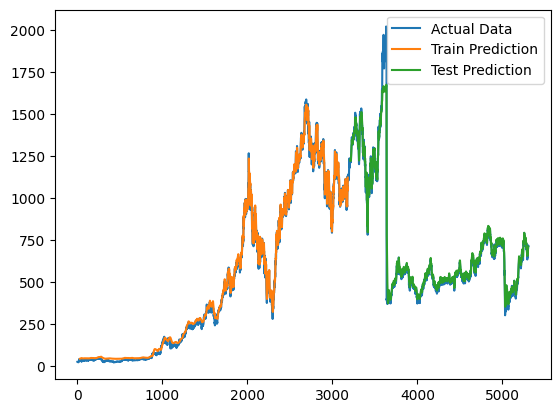

In [81]:
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(train_predict) + lookback] = train_predict

testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (lookback * 2) : len(train_predict) + (lookback * 2) + len(test_predict)] = test_predict

plt.plot(scaler.inverse_transform(df), label='Actual Data')
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.legend()
plt.show()

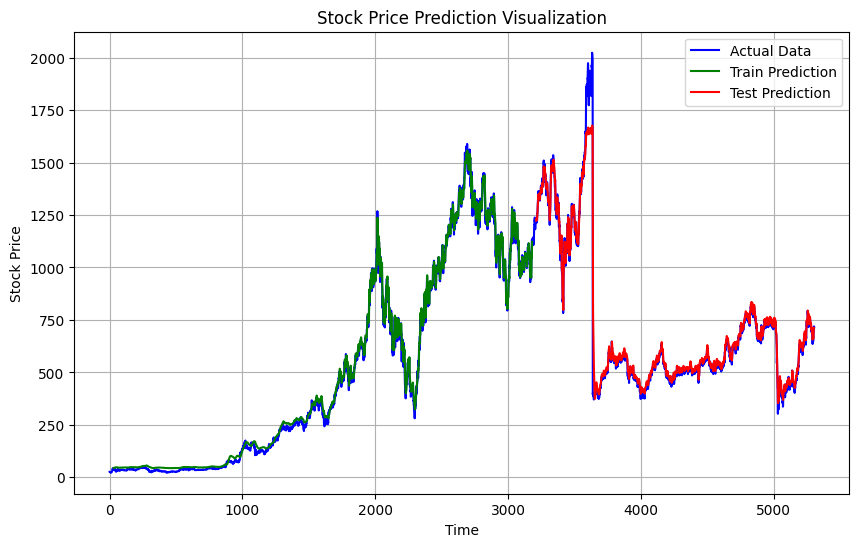

In [82]:
# Visualisation block for better understanding
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(df), label='Actual Data', color='blue')
plt.plot(trainPredictPlot, label='Train Prediction', color='green')
plt.plot(testPredictPlot, label='Test Prediction', color='red')
plt.title('Stock Price Prediction Visualization')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()